In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 01. ResNet 기본 블록 구성

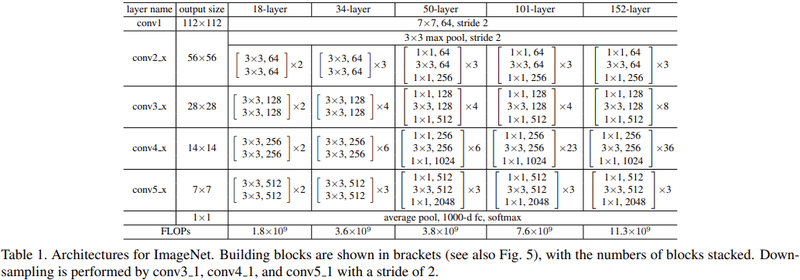

In [36]:
def build_res34_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   block_num=1,
                   shortCut=None,
                   is_plain=False
                   ):
    
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        
        shortCut_channel=shortCut.shape.as_list()[-1]
        if shortCut_channel != channel:
            
            x = keras.layers.Conv2D(filters=channel,
                                            kernel_size=(3,3),
                                            strides=2,
                                            padding='same',
                                            name=f'block{block_num}_{cnn_num}_conv1'
                                           )(x)
        else:
            x = keras.layers.Conv2D(filters=channel,
                                            kernel_size=(3,3),
                                            padding='same',
                                            name=f'block{block_num}_{cnn_num}_conv1'
                                           )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn1')(x)
        x = keras.layers.Activation('relu',name=f'block{block_num}_{cnn_num}_act1')(x)
        x = keras.layers.Conv2D(filters=channel,
                                            kernel_size=(3,3),
                                            padding='same',
                                            name=f'block{block_num}_{cnn_num}_conv2'
                                           )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn2')(x)

        if not is_plain:
            if shortCut_channel != channel:
                shortCut = keras.layers.Conv2D(channel, (1,1),strides=2, padding='same',name=f'block{block_num}_short_conv')(shortCut)
                shortCut = keras.layers.BatchNormalization(name=f'block{block_num}_short_bn')(shortCut)

            x = keras.layers.Add()([x,shortCut])
        x = keras.layers.Activation('relu')(x)
        shortCut=x
            
    return x

In [37]:
def build_res_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   block_num=1,
                   shortCut=None,
                   is_plain=False
                   ):
    
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        shortCut_channel=shortCut.shape.as_list()[-1]
        
        # 1x1
        if shortCut_channel != channel*4 and shortCut_channel != channel:
            x = keras.layers.Conv2D(filters=channel,
                                            kernel_size=(1,1),
                                            strides=2,
                                            padding='same',
                                            name=f'block{block_num}_{cnn_num}_conv1'
                                            )(x)
        else:
            x = keras.layers.Conv2D(filters=channel,
                                            kernel_size=(1,1),
                                            padding='same',
                                            name=f'block{block_num}_{cnn_num}_conv1'
                                            )(x)
            
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn1')(x)
        x = keras.layers.Activation('relu',name=f'block{block_num}_{cnn_num}_act1')(x)
        
        # 3x3
        x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3,3),
                                        padding='same',
                                        name=f'block{block_num}_{cnn_num}_conv2'
                                        )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn2')(x)
        x = keras.layers.Activation('relu',name=f'block{block_num}_{cnn_num}_act2')(x)
        
        # 1x1
        x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1,1),
                                        padding='same',
                                        name=f'block{block_num}_{cnn_num}_conv3'
                                        )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn3')(x)
         
        if not is_plain:
            if shortCut_channel != channel*4:
                if shortCut.shape.as_list()[1] == x.shape.as_list()[1]:
                    shortCut = keras.layers.Conv2D(channel*4, (1,1), padding='same',name=f'block{block_num}_short_conv')(shortCut)
                else:
                    shortCut = keras.layers.Conv2D(channel*4, (1,1),strides=2, padding='same',name=f'block{block_num}_short_conv')(shortCut)
                shortCut = keras.layers.BatchNormalization(name=f'block{block_num}_short_bn')(shortCut)    
            x = keras.layers.Add()([x,shortCut])
        x = keras.layers.Activation('relu')(x)
        shortCut=x
    
    return x

In [38]:
def build_res_plain(input_shape=(224,224,3),
             num_cnn_list=[3,4,6,3],
             channel_list=[64,128,256,512],
             num_classes=2,
             is_34=True,
             is_plain=False
             ):
    
    # 모델을 만들기 전에 config list들이 같은 길이인지 확인
    assert len(num_cnn_list) == len(channel_list)
    
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer 생성
    output = input_layer
    
    # Conv1
    output = keras.layers.Conv2D(
                            filters=64, 
                            kernel_size=(7,7),
                            strides=2,
                            padding='same', 
                            kernel_initializer='he_normal',
                            name='block1_conv'
                            )(output)
    output = keras.layers.BatchNormalization(name=f'block1_bn')(output)
    output = keras.layers.Activation('relu',name=f'block1_act')(output)
    
    # Max Pooling
    output = keras.layers.MaxPooling2D((3,3), 2, padding='same')(output)
    
    shortCut=output
    
    # config list들의 길이만큼 반복해서 블록 생성
    if is_34 :
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_res34_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                block_num=i+2,
                shortCut=shortCut,
                is_plain=is_plain
                 )
            shortCut = output
    else:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_res_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                block_num=i+2,
                shortCut=shortCut,
                is_plain=is_plain
                )
            shortCut = output
    
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(2, activation='softmax')(output)


    model = keras.Model(
        inputs = input_layer,
        outputs = output)
    
    return model

# 02. ResNet-34, ResNet-50 Complete Model

In [39]:
res_34 = build_res_plain(input_shape=(224,224,3), is_34=True)

res_34.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv (Conv2D)            (None, 112, 112, 64) 9472        input_15[0][0]                   
__________________________________________________________________________________________________
block1_bn (BatchNormalization)  (None, 112, 112, 64) 256         block1_conv[0][0]                
__________________________________________________________________________________________________
block1_act (Activation)         (None, 112, 112, 64) 0           block1_bn[0][0]                  
____________________________________________________________________________________________

In [66]:
res_50 = build_res_plain(input_shape=(224,224,3), is_34=False)

res_50.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv (Conv2D)            (None, 112, 112, 64) 9472        input_19[0][0]                   
__________________________________________________________________________________________________
block1_bn (BatchNormalization)  (None, 112, 112, 64) 256         block1_conv[0][0]                
__________________________________________________________________________________________________
block1_act (Activation)         (None, 112, 112, 64) 0           block1_bn[0][0]                  
____________________________________________________________________________________________

# 03. 일반 네트워크(plain network)

In [41]:
plain_34 = build_res_plain(input_shape=(224,224,3), is_34=True, is_plain=True)
plain_34.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
block1_bn (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
block1_act (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
block2_0_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
block2_0_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [67]:
plain_50 = build_res_plain(input_shape=(224,224,3), is_34=False, is_plain=True)
plain_50.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
block1_bn (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
block1_act (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
block2_0_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
block2_0_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

# 04. Data Load

In [43]:
import os


_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
file_name=os.getenv('HOME')+'/aiffel/cats_dogs/cats_and_dogs.zip'
path_to_zip = tf.keras.utils.get_file(file_name, origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH

'/aiffel/aiffel/cats_dogs/cats_and_dogs_filtered'

In [44]:
cat_path = PATH + '/train/cats/'
dog_path = PATH + '/train/dogs/'
cat_val_path = PATH + '/validation/cats/'
dog_val_path = PATH + '/validation/dogs/'

print("number of cat train examples :", len(os.listdir(cat_path)))
print("number of dog train examples :", len(os.listdir(dog_path)))
print("number of cat validation examples :", len(os.listdir(cat_val_path)))
print("number of dog validation examples :", len(os.listdir(dog_val_path)))

number of cat train examples : 1000
number of dog train examples : 1000
number of cat validation examples : 500
number of dog validation examples : 500


In [45]:
total_train_num = len(os.listdir(cat_path))+len(os.listdir(dog_path))
total_val_num = len(os.listdir(cat_val_path))+len(os.listdir(dog_val_path))

In [53]:
import cv2

# 이미지 크기 확인
f = cat_path + os.listdir(cat_path)[1]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

f = dog_path + os.listdir(dog_path)[1]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(400, 399, 3)
(233, 350, 3)


이미지 크기가 다 다름

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
epochs = 35
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_dir = PATH + '/train/'
val_dir = PATH + '/validation/'

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


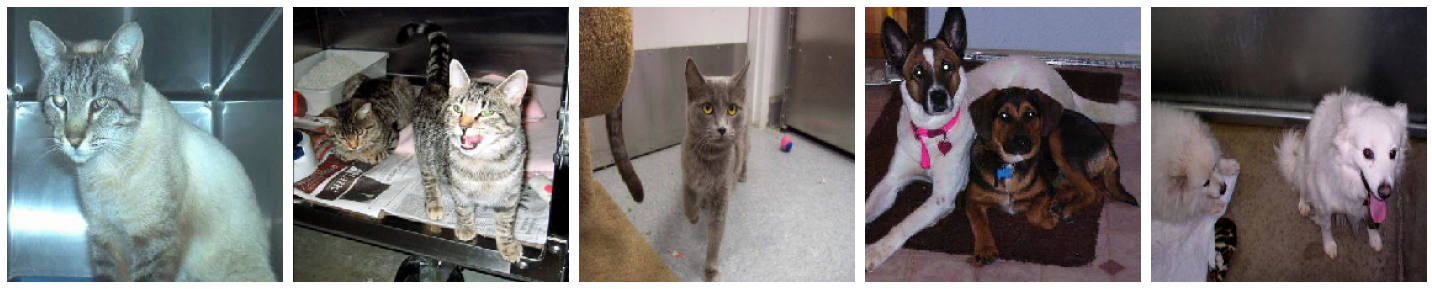

In [55]:
# 데이터 확인
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

# 04. ResNet-34 vs Plain-34

In [56]:
# ResNet-34
res_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy'])

history_res34 = res_34.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen)


Epoch 1/25
125/125 [==============================] - 60s 166ms/step - loss: 0.7459 - accuracy: 0.5695 - val_loss: 0.7806 - val_accuracy: 0.5000
Epoch 2/25
125/125 [==============================] - 17s 133ms/step - loss: 0.7210 - accuracy: 0.5900 - val_loss: 1.0085 - val_accuracy: 0.5130
Epoch 3/25
125/125 [==============================] - 16s 131ms/step - loss: 0.6385 - accuracy: 0.6415 - val_loss: 0.7206 - val_accuracy: 0.6050
Epoch 4/25
125/125 [==============================] - 16s 129ms/step - loss: 0.5637 - accuracy: 0.7150 - val_loss: 0.6649 - val_accuracy: 0.6220
Epoch 5/25
125/125 [==============================] - 16s 130ms/step - loss: 0.5303 - accuracy: 0.7385 - val_loss: 0.6712 - val_accuracy: 0.6830
Epoch 6/25
125/125 [==============================] - 16s 131ms/step - loss: 0.4356 - accuracy: 0.8045 - val_loss: 0.7648 - val_accuracy: 0.6930
Epoch 7/25
125/125 [==============================] - 16s 130ms/step - loss: 0.3803 - accuracy: 0.8250 - val_loss: 1.7609 - val_ac

In [57]:
# Plain-34

plain_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy'])

history_plain34 = plain_34.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen)


Epoch 1/25
125/125 [==============================] - 19s 131ms/step - loss: 0.7191 - accuracy: 0.5470 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 2/25
125/125 [==============================] - 16s 125ms/step - loss: 0.7004 - accuracy: 0.5715 - val_loss: 0.7181 - val_accuracy: 0.5160
Epoch 3/25
125/125 [==============================] - 16s 126ms/step - loss: 0.6777 - accuracy: 0.5930 - val_loss: 0.7443 - val_accuracy: 0.5660
Epoch 4/25
125/125 [==============================] - 16s 126ms/step - loss: 0.6562 - accuracy: 0.6135 - val_loss: 0.6870 - val_accuracy: 0.6240
Epoch 5/25
125/125 [==============================] - 16s 127ms/step - loss: 0.6576 - accuracy: 0.6320 - val_loss: 1.0694 - val_accuracy: 0.5900
Epoch 6/25
125/125 [==============================] - 16s 126ms/step - loss: 0.6377 - accuracy: 0.6410 - val_loss: 0.6838 - val_accuracy: 0.6230
Epoch 7/25
125/125 [==============================] - 16s 127ms/step - loss: 0.6259 - accuracy: 0.6635 - val_loss: 0.7051 - val_ac

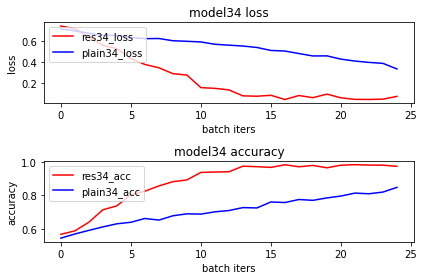

In [58]:
# summarize history for loss  
plt.subplot(211)  
plt.plot(history_res34.history['loss'],'r')  
plt.plot(history_plain34.history['loss'], 'b')  
plt.title('model34 loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['res34_loss', 'plain34_loss'], loc='upper left')  

# summarize history for accuracy  
plt.subplot(212)  
plt.plot(history_res34.history['accuracy'], 'r')  
plt.plot(history_plain34.history['accuracy'], 'b')  
plt.title('model34 accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('batch iters')  
plt.legend(['res34_acc', 'plain34_acc'], loc='upper left')  
    
plt.tight_layout()

plt.show()

# 05. ResNet-50 vs Plain-50

In [68]:
# ResNet-50

# batch size = 16 조정
# epoch = 35 조정
res_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy'])

history_res50 = res_50.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen)


Epoch 1/35
125/125 [==============================] - 31s 216ms/step - loss: 0.8960 - accuracy: 0.5270 - val_loss: 0.6897 - val_accuracy: 0.5400
Epoch 2/35
125/125 [==============================] - 27s 212ms/step - loss: 0.8501 - accuracy: 0.5355 - val_loss: 0.7588 - val_accuracy: 0.5010
Epoch 3/35
125/125 [==============================] - 26s 206ms/step - loss: 0.8282 - accuracy: 0.5605 - val_loss: 0.7078 - val_accuracy: 0.6070
Epoch 4/35
125/125 [==============================] - 26s 207ms/step - loss: 0.8289 - accuracy: 0.5985 - val_loss: 1.5704 - val_accuracy: 0.5780
Epoch 5/35
125/125 [==============================] - 26s 209ms/step - loss: 0.7754 - accuracy: 0.6110 - val_loss: 0.7361 - val_accuracy: 0.6490
Epoch 6/35
125/125 [==============================] - 26s 207ms/step - loss: 0.7017 - accuracy: 0.6415 - val_loss: 1.0635 - val_accuracy: 0.5400
Epoch 7/35
125/125 [==============================] - 26s 208ms/step - loss: 0.6901 - accuracy: 0.6505 - val_loss: 2.3516 - val_ac

In [69]:
# plain 50

plain_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy'])

history_plain50 = plain_50.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen)


Epoch 1/35
125/125 [==============================] - 26s 184ms/step - loss: 0.7226 - accuracy: 0.5105 - val_loss: 2.4051 - val_accuracy: 0.5000
Epoch 2/35
125/125 [==============================] - 22s 176ms/step - loss: 0.8077 - accuracy: 0.5180 - val_loss: 1.1041 - val_accuracy: 0.5000
Epoch 3/35
125/125 [==============================] - 22s 175ms/step - loss: 0.7501 - accuracy: 0.5240 - val_loss: 0.7240 - val_accuracy: 0.5270
Epoch 4/35
125/125 [==============================] - 22s 175ms/step - loss: 0.7392 - accuracy: 0.4935 - val_loss: 0.7969 - val_accuracy: 0.5600
Epoch 5/35
125/125 [==============================] - 22s 179ms/step - loss: 0.7162 - accuracy: 0.5290 - val_loss: 0.7075 - val_accuracy: 0.5780
Epoch 6/35
125/125 [==============================] - 22s 175ms/step - loss: 0.7180 - accuracy: 0.5320 - val_loss: 0.8076 - val_accuracy: 0.5470
Epoch 7/35
125/125 [==============================] - 22s 173ms/step - loss: 0.7080 - accuracy: 0.5410 - val_loss: 0.6775 - val_ac

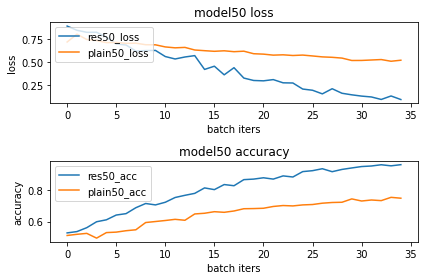

In [70]:
# summarize history for loss  
plt.subplot(211)  
plt.plot(history_res50.history['loss'])  
plt.plot(history_plain50.history['loss'])  
plt.title('model50 loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['res50_loss', 'plain50_loss'], loc='upper left')  

# summarize history for accuracy  
plt.subplot(212)  
plt.plot(history_res50.history['accuracy'])  
plt.plot(history_plain50.history['accuracy'])  
plt.title('model50 accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('batch iters')  
plt.legend(['res50_acc', 'plain50_acc'], loc='upper left')  
    
plt.tight_layout()

plt.show()

||ResNet | Plain|
|---|---|---|
|layer 34| 0.7190 | 0.6700 |
|layer 50| 0.6990 | 0.6830 |

위 표는 각각 layer 갯수 34개와 50개 에서의 ResNet 사용했을 때와 사용하지않았을 때의 validation dataset에 대한 최대 accuracy입니다.

- epoch는 34개 층에 25, 50개 층에 35
- GPU문제로 batch는16

Plain loss 그래프를 보면 loss가 잘 떨어지지 않고 있고 학습이 제대로 이루지지않고 있습니다.\
그에 반해 ResNet을 사용했을 때의 loss는 Plain보다 낮게 잘 떨어지고 있습니다.\
즉, 사용하지않았을 때 대비 학습이 잘 이루어지고 있다고 볼 수 있습니다.\

위의 34개 층 모델같은 경우 accuracy표를 보면 ResNet의 정확도가 조금더 좋게 나왔습니다,\
50개의 layer 갯수로 쌓은 모델의 경우 근소한 차이로 ResNet이 더 높긴 하지만,\
학습이 조금 더 이루어진다면 차이가 더 벌어질 것으로 예상이 됩니다.

# 회고

ResNet 잔차 계산시에 shape을 맞춰주는 데에 어려움을 느꼈습니다.\
Res34의 경우 현재 channel과 들어온 shortCut의 크기가 다를 경우 1x1 conv layer를 통해 reshape 해주었고,\
Res50같은 경우 현재 channel 크기와 들어오는 residual의 크기가 항상 달랐습니다.\
그래서 channel에 4를 곱해준 값과 크기가 같은 경우 같은 블럭안에서 돌기 때문에\
Max Pooling을 거쳐 처음 들어간 잔차;shortCut을 제외하고\
현재 채널수의 4배가 shape[-1]과 다를 경우 convolution layer에 넣어주어 크기를 맞춰 주었습니다.